# Modelling the climate and the weather

### Heather Tweedie, March 2023

GHCN (Global Historical Climatology Network)-Daily is a database of daily climate summaries from land surface stations across the globe. This study aims to determine if the weather and climate at a location can be predicted using basic machine learning techniques. Two main research questions are proposed:
1. How accurately can a model predict the climate of a location a year in advance?
2. Can a model predict the weather at a location any better than assuming the weather tomorrow will be the same as the weather today?

This notebook will focus on the second of these questions.


Journal article describing GHCN-Daily:
Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.

Dataset used:
Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - Daily (GHCN-Daily), Version 3.12, NOAA National Climatic Data Center. http://doi.org/10.7289/V5D21VHZ

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-22 20:31:00.865285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 20:31:01.151345: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 20:31:01.188998: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 20:31:01.189040: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
f = open('data/stat_counts_tmax.json')
counts_tmax = json.load(f)
f = open('data/stat_counts_prcp.json')
counts_prcp = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [name for name, count in counts_tmax.items() if count <= 100]
print(f"Number of tmax stations found: {len(no_gaps_tmax)}")
no_gaps_prcp = [name for name, count in counts_prcp.items() if count <= 100]
print(f"Number of prcp stations found: {len(no_gaps_prcp)}")

good_stations = list(set(no_gaps_tmax).intersection(no_gaps_prcp))
print(f"Number of stations with few temp and precip gaps: {len(good_stations)}")

Number of tmax stations found: 103
Number of prcp stations found: 112
Number of stations with few temp and precip gaps: 76


### Get data, and shape train, validate and test arrays

In [3]:
# create instance of the GHCND class and extract information on countries and stations from their respective files
ghn = GHCND()
ghn.readCountriesFile()
ghn.readStationsFile()

# get list of station names
station_names = ghn.getStatKeyNames()

# set station to be investigated
#station = good_stations[50]
station = 'ASN00030124'
print(f"Station selected: {station}")

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/stations_daily/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(f"Station details: {ghn.getStation(station)}")

# extract data for specified variable into an instance of the Variable class
tmax = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
tmax.convert_time()
tmax_dates = tmax.get_dates()
tmax_vals = tmax.get_vals()
print(f"Extracted {len(tmax_vals)} maximum temperature values")

prcp = Variable(ghn.getVar(station_data, 'PRCP'), "precipitation (mm)", ghn.stationDict[station].name)
prcp.convert_time()
prcp_dates = prcp.get_dates()
prcp_vals = prcp.get_vals()
print(f"Extracted {len(prcp_vals)} precipitation values")


Read 219 countries and codes
Read 991 stations from the GSN
Station selected: ASN00030124
Filename: ASN00030124.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/ASN00030124.dly
destination: data/stations_daily/ASN00030124.dly
Station details: ASN00030124 is GEORGETOWN AIRPORT, Australia at -18.3039 143.5306 301.8
Extracted 5930 maximum temperature values
Extracted 5958 precipitation values


Text(0, 0.5, 'Normalised daily precipitation')

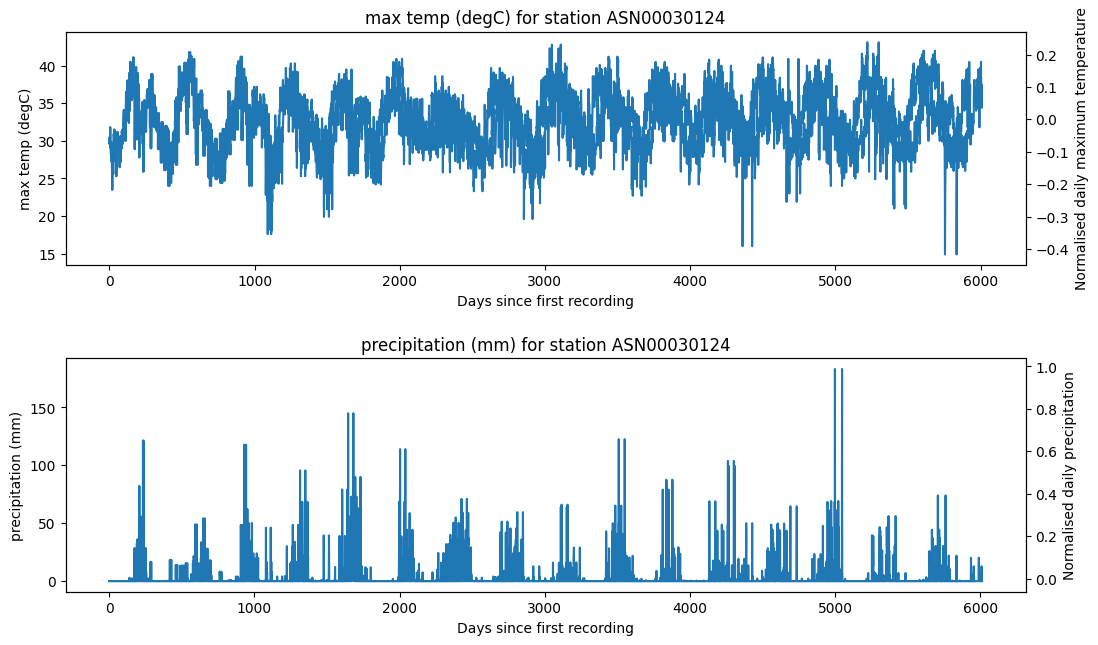

In [4]:
# normalise data, and save means and maximums for later use
tmax_normalised = tmax.normalise(tmax_vals)
tmax_mean = np.mean(tmax_vals)
tmax_max = np.max(tmax_vals)
prcp_normalised = prcp.normalise(prcp_vals)
prcp_mean = np.mean(prcp_vals)
prcp_max = np.max(prcp_vals)

# plot means and normalised means
fig, ax = plt.subplots(2, 1, figsize = (12, 7))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
ax[0].plot(tmax_dates, tmax_vals)
ax[0].set_xlabel("Days since first recording")
ax[0].set_ylabel(f"{tmax.get_label()}")
ax[0].set_title(f"{tmax.get_label()} for station {station}")
ax2 = ax[0].twinx()
ax2.plot(tmax_normalised)
ax2.set_ylabel("Normalised daily maximum temperature")

ax[1].plot(prcp_dates, prcp_vals)
ax[1].set_xlabel("Days since first recording")
ax[1].set_ylabel(f"{prcp.get_label()}")
ax[1].set_title(f"{prcp.get_label()} for station {station}")
ax2 = ax[1].twinx()
ax2.plot(prcp_normalised)
ax2.set_ylabel("Normalised daily precipitation")

plt.savefig('figures/weather_input_data.svg', format = 'svg')



In [5]:
WINDOW_SIZE = 60
OFFSET = 1

# make sure arrays are the same length
if len(tmax_normalised > len(prcp_normalised)):
    tmax_normalised = tmax_normalised[:len(prcp_normalised)]
if len(prcp_normalised > len(tmax_normalised)):
    prcp_normalised = prcp_normalised[:len(tmax_normalised)]

# join all variable arrays into one n-d array
all_vals = np.vstack((tmax_normalised, prcp_normalised)).T
print(f"Shape of combined data: {np.shape(all_vals)}")
print(all_vals[:10])

# calculate appropriate divisions of data
test_len = int(len(all_vals) * 0.2)
train_len = int(len(all_vals) * 0.7)
validate_len = int(len(all_vals) * 0.1)

print(f"Length of training data: {train_len}")
print(f"Length of validation data: {validate_len}")
print(f"Length of testing data: {test_len}")

# divide data into training, validating and testing sets
test = all_vals[:test_len,:]
train = all_vals[test_len+1:test_len+train_len,:]
validate = all_vals[test_len+train_len+1:,:]

# split data into input windows and targets
input_test, target_test = shapeArray(test, WINDOW_SIZE, OFFSET)
input_train, target_train = shapeArray(train, WINDOW_SIZE, OFFSET)
input_validate, target_validate = shapeArray(validate, WINDOW_SIZE, OFFSET)

# reshape the data into the correct format for input into the model
n_features = 2
print(f"Training input shape before reshaping: {np.shape(input_train)}")
print("Head before reshaping:")
print(input_train[:10])
input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))
print(f"Training input shape after reshaping: {np.shape(input_train)}")
print("Head after reshaping:")
print(input_train[:10])



Shape of combined data: (5930, 2)
[[-0.05708204 -0.01194863]
 [-0.07564353 -0.01194863]
 [-0.06636279 -0.01194863]
 [-0.07332334 -0.01194863]
 [-0.05940223 -0.01194863]
 [-0.06868297 -0.01194863]
 [-0.02459945 -0.01194863]
 [-0.06636279 -0.01194863]
 [-0.08724446 -0.01194863]
 [-0.08260409 -0.01194863]]
Length of training data: 4151
Length of validation data: 593
Length of testing data: 1186
Training input shape before reshaping: (4090, 60, 2)
Head before reshaping:
[[[ 0.05428687 -0.01194863]
  [ 0.05428687 -0.01194863]
  [ 0.07980891 -0.01194863]
  ...
  [ 0.09373002 -0.01194863]
  [ 0.09140984 -0.01194863]
  [ 0.10765113  0.0710208 ]]

 [[ 0.05428687 -0.01194863]
  [ 0.07980891 -0.01194863]
  [ 0.07980891 -0.01194863]
  ...
  [ 0.09140984 -0.01194863]
  [ 0.10765113  0.0710208 ]
  [ 0.10069058 -0.01194863]]

 [[ 0.07980891 -0.01194863]
  [ 0.07980891 -0.01194863]
  [ 0.03804557 -0.01194863]
  ...
  [ 0.10765113  0.0710208 ]
  [ 0.10069058 -0.01194863]
  [ 0.12157225 -0.01194863]]

 

2023-03-22 20:31:06.132215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 20:31:06.132305: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 20:31:06.132342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-03-22 20:31:06.133194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          17152     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 116,226
Trainable params: 116,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
128/128 [==============================] - 8s 46ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 2/50
128/128 [==============================] - 6s 50ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 3/50
128/128 [==============================] - 7s 52ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 4/50


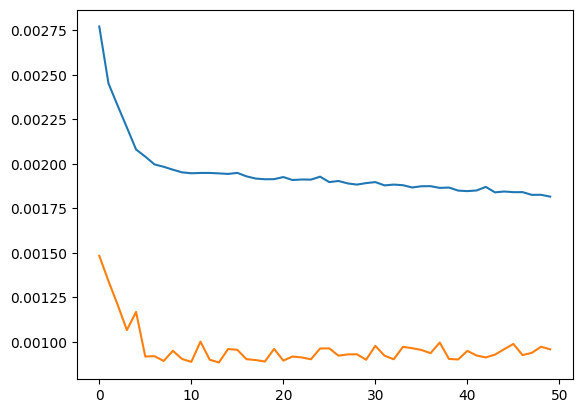

In [6]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape = (None, 2), activation = 'relu', return_sequences = True))
model.add(layers.LSTM(128, activation = 'relu', return_sequences = False))
model.add(layers.Dense(2, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 50, validation_data = (input_validate, target_validate))
cost = history.history['loss']
val_cost = history.history['val_loss']


Text(0.5, 1.0, 'Training and validation loss')

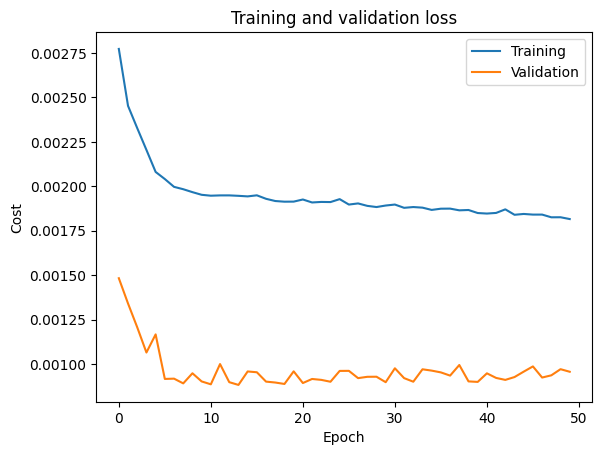

In [9]:
fig, ax = plt.subplots()
ax.plot(cost, label = "Training")
ax.plot(val_cost, label = "Validation")
ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Training and validation loss")
plt.savefig('figures/weather_loss.svg', format = 'svg')


36/36 [==============================] - 1s 20ms/step
(1126, 2)


Text(0.5, 1.0, 'Observed precipitation')

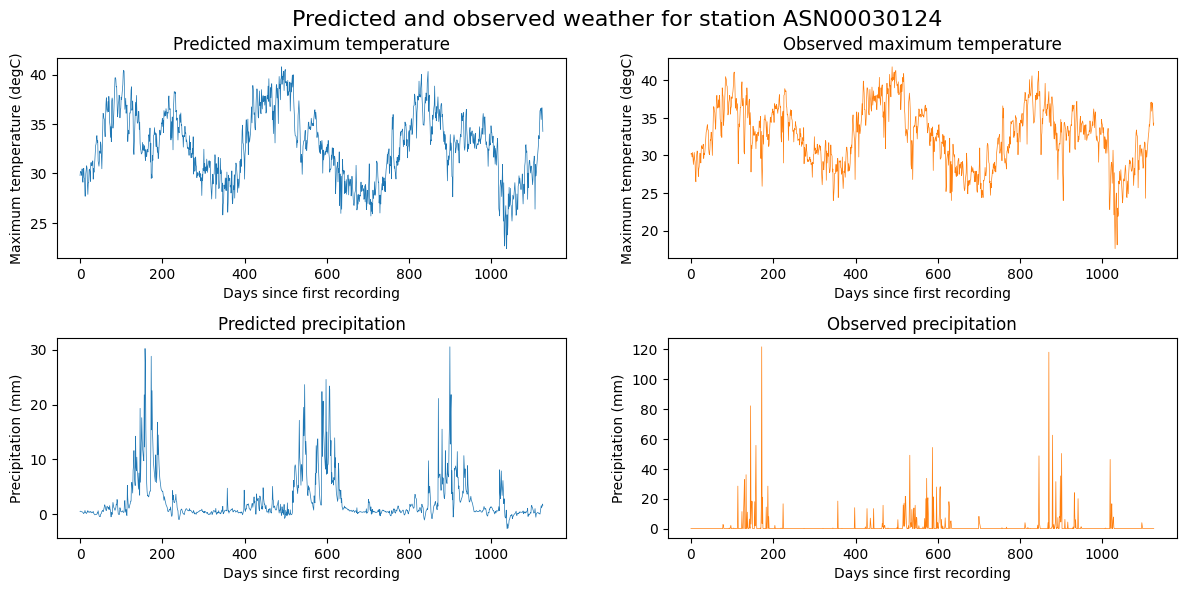

In [7]:
prediction = model.predict(input_test)
print(np.shape(prediction))

# de-normalise data for plotting
plot_target_tmax = (tmax.de_normalise(target_test[:,0], tmax_max, tmax_mean))
plot_pred_tmax = (tmax.de_normalise(prediction[:,0], tmax_max, tmax_mean))
plot_target_prcp = (prcp.de_normalise(target_test[:,1], prcp_max, prcp_mean))
plot_pred_prcp = (prcp.de_normalise(prediction[:,1], prcp_max, prcp_mean))

# plot observed and predicted data
fig, ax = plt.subplots(2,2, figsize = (14, 6))
fig.suptitle(f"Predicted and observed weather for station {station}", fontsize = 16)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

ax[0,0].plot(plot_pred_tmax, color = 'tab:blue', linewidth = 0.5)
ax[0,0].set_xlabel("Days since first recording")
ax[0,0].set_ylabel("Maximum temperature (degC)")
ax[0,0].set_title(f"Predicted maximum temperature")

ax[0,1].plot(plot_target_tmax, color = 'tab:orange', linewidth = 0.5)
ax[0,1].set_xlabel("Days since first recording")
ax[0,1].set_ylabel("Maximum temperature (degC)")
ax[0,1].set_title(f"Observed maximum temperature")

ax[1,0].plot(plot_pred_prcp, color = 'tab:blue', linewidth = 0.5)
ax[1,0].set_xlabel("Days since first recording")
ax[1,0].set_ylabel("Precipitation (mm)")
ax[1,0].set_title(f"Predicted precipitation")

ax[1,1].plot(plot_target_prcp, color = 'tab:orange', linewidth = 0.5)
ax[1,1].set_xlabel("Days since first recording")
ax[1,1].set_ylabel("Precipitation (mm)")
ax[1,1].set_title(f"Observed precipitation")

plt.savefig('figures/weather_prediction.svg', format = 'svg')



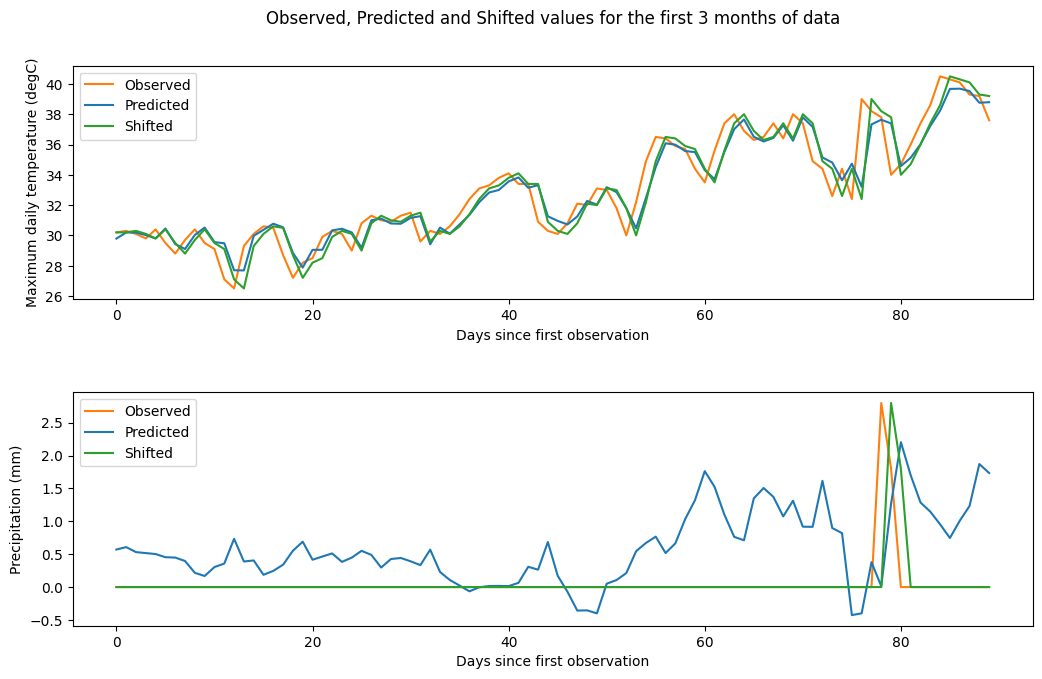

In [11]:
months_to_plot = 3
shifted_tmax = shift(plot_target_tmax)
shifted_prcp = shift(plot_target_prcp)

fig, ax = plt.subplots(2, 1, figsize = (12, 7))
fig.suptitle(f"Observed, Predicted and Shifted values for the first {months_to_plot} months of data")
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

ax[0].plot(plot_target_tmax[:months_to_plot*30], label = "Observed", color = 'tab:orange')
ax[0].plot(plot_pred_tmax[:months_to_plot*30], label = "Predicted", color = 'tab:blue')
ax[0].plot(shifted_tmax[:months_to_plot*30], label = "Shifted", color = 'tab:green')
ax[0].set_xlabel("Days since first observation")
ax[0].set_ylabel("Maximum daily temperature (degC)")
ax[0].legend()

ax[1].plot(plot_target_prcp[:months_to_plot*30], label = "Observed", color = 'tab:orange')
ax[1].plot(plot_pred_prcp[:months_to_plot*30], label = "Predicted", color = 'tab:blue')
ax[1].plot(shifted_prcp[:months_to_plot*30], label = "Shifted", color = 'tab:green')
ax[1].set_xlabel("Days since first observation")
ax[1].set_ylabel("Precipitation (mm)")
ax[1].legend()

plt.savefig('figures/weather_detailed_prediction.svg', format = 'svg')



### Least mean-squared

Sum of the squared errors.

In [ ]:
fake_mse_tmax = weather_fake_mse(tmax_vals)
print(fake_mse_tmax)

fake_mse_prcp = weather_fake_mse(prcp_vals)
print(fake_mse_prcp)


11.568425205726644
291.83682624379685
